In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt

import cv2



In [0]:
pip install opencv-python

In [0]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator,self).__init__()
        self.model = nn.Sequential(nn.Conv2d(1,128,4,2,1, bias=True),
                                   nn.BatchNorm2d(128),
                                   nn.LeakyReLU(0.2,True),

                                   nn.Conv2d(128,256,4,2,1,bias=True),
                                   nn.BatchNorm2d(256),
                                   nn.LeakyReLU(0.2,True),

                                   nn.Conv2d(256,512,4,2,1,bias=True),
                                   nn.BatchNorm2d(512),
                                   nn.LeakyReLU(0.2,True),

                                   nn.Conv2d(512,1024,4,2,1,bias=True), 
                                   nn.BatchNorm2d(1024),
                                   nn.LeakyReLU(0.2,True),

                                   nn.Conv2d(1024,1,4,1,0,bias=True),
                                   nn.Sigmoid()
                                   )
    

    def forward(self, x):
        return self.model(x)
    
    

In [0]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            
            
                                   nn.ConvTranspose2d(100,1024,4,2,0,bias=True),
                                   nn.BatchNorm2d(1024),
                                   nn.LeakyReLU(0.2,True),
                                   
                                   nn.ConvTranspose2d(1024,512,4,2,1,bias=True),
                                   nn.BatchNorm2d(512),
                                   nn.LeakyReLU(0.2,True),
                                   
                                   nn.ConvTranspose2d(512,256,4,2,1,bias=True),
                                   nn.BatchNorm2d(256),
                                   nn.LeakyReLU(0.2,True),
                                   
                                   nn.ConvTranspose2d(256,128,4,2,1,bias=True),
                                   nn.BatchNorm2d(128),
                                   nn.LeakyReLU(0.2,True),
                                   
                                   nn.ConvTranspose2d(128,1,4,2,1),
                                   nn.Tanh()
                                   )
        
        
    def forward(self, x):
        return self.model(x)
        
    

In [0]:
import numpy as np
from urllib import request
import gzip
import pickle

filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]


In [0]:


init()


training_images_prev, training_labels, test_images_prev, test_labels = load()

NUM_TRAINING_IMAGES = training_images_prev.shape[0]
NUM_TEST_IMAGES = test_images_prev.shape[0]

training_images_prev = np.array(training_images_prev).reshape((NUM_TRAINING_IMAGES,28,28))
test_images_prev = np.array(test_images_prev).reshape((NUM_TEST_IMAGES,28,28))

training_images = []

for img in training_images_prev:
  res = cv2.resize(img, dsize=(64,64), interpolation=cv2.INTER_CUBIC)
  training_images.append(res)

training_images = np.array(training_images)

test_images = []
for img in test_images_prev:
  res = cv2.resize(img, dsize=(64,64), interpolation=cv2.INTER_CUBIC)
  test_images.append(res)

test_images = np.array(test_images)



training_images = training_images.reshape(NUM_TRAINING_IMAGES, 1, 64, 64) / 127.5 -1
test_images = test_images.reshape(NUM_TEST_IMAGES, 1, 64, 64) / 127.5 -1





Download complete.
Save complete.


In [0]:
def display_images(images):
    fig = plt.figure(figsize=(10,10))
    columns= 5
    rows = 5
    
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        img = images[i].reshape((64,64))
        plt.imshow(img)
    plt.show()



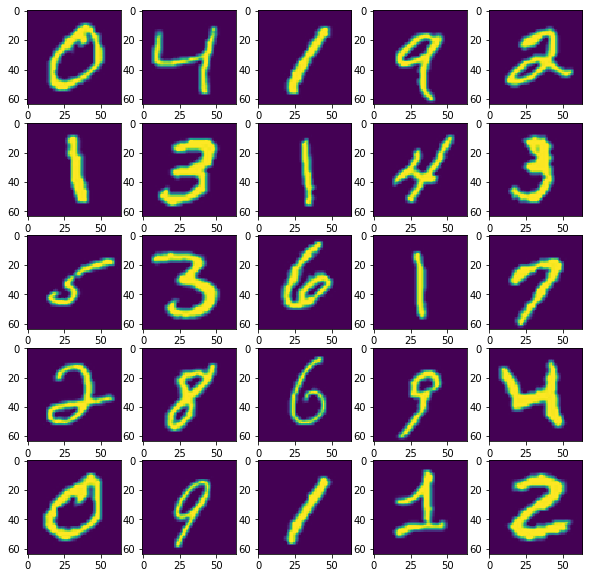

In [0]:
display_images(training_images[:26])


In [0]:

def convert_to_cuda(non_cuda):
    if torch.cuda.is_available():
        return non_cuda.cuda()
    return non_cuda
    

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:

loss_function = nn.BCELoss()

convert_to_cuda(Generator())
discriminator = convert_to_cuda(Discriminator())
generator = convert_to_cuda(Generator())

generator.apply(weights_init)

discriminator.apply(weights_init)



Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
    (13): Sigmoid()

In [0]:

generator_optimizer = torch.optim.Adam(generator.parameters(),0.0002, (0.5, 0.9))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), 0.0002, (0.5,0.9))

In [0]:

EPOCHS = 2
BATCH_SIZE = 128

D_LOSS_THRESHOLD = 1.0


In [0]:
for e in range(EPOCHS):
  for b in range(NUM_TRAINING_IMAGES//BATCH_SIZE):
    
    
    # TRAIN DISCRIMINATOR
    
    D_LOSS = 0 
    
    # TRAIN ON REAL BATCH
    
    discriminator.zero_grad()
    
    x = convert_to_cuda(torch.tensor(training_images[b*BATCH_SIZE: (b+1)*BATCH_SIZE], dtype=torch.float32))
    y = convert_to_cuda(torch.ones((BATCH_SIZE, 1, 1, 1)))
    
    yhat = discriminator(x)
    
    
    loss = loss_function(yhat,y)
    loss.backward()
    
    D_LOSS += loss.mean().item()
    
    # TRAIN ON FAKE BATCH
    image_noise = convert_to_cuda(torch.randn([BATCH_SIZE, 100, 1, 1]))
    
    x = fake_images = generator(image_noise.detach())
    y = convert_to_cuda(torch.zeros((BATCH_SIZE,1,1,1)))
    
    yhat = discriminator(fake_images.detach())

    
    loss = loss_function(yhat,y)
    loss.backward()
    
    D_LOSS += loss.mean().item()
    
    if D_LOSS > D_LOSS_THRESHOLD:
      discriminator_optimizer.step()
    
    
    
    # TRAIN GENERATOR
    
    generator.zero_grad()
    
    y = convert_to_cuda(torch.ones((BATCH_SIZE,1,1,1)))
    yhat = discriminator(generator(image_noise))
    
    loss = loss_function(yhat,y)
    loss.backward()
    
    G_LOSS = loss.mean().item()
    
    generator_optimizer.step()
    
    
    if b % 10 == 0:
      print("Epoch " + str(e+1) + "/" + str(EPOCHS) +  "   Batch " + str(b+1)+ "/" + str(NUM_TRAINING_IMAGES//BATCH_SIZE) + "    G_LOSS: " + str(G_LOSS) +"   D_LOSS: " + str(D_LOSS))
      
  print("Epoch " + str(e+1) + "/" + str(EPOCHS) +  "   Batch " + str(NUM_TRAINING_IMAGES//BATCH_SIZE)+ "/" + str(NUM_TRAINING_IMAGES//BATCH_SIZE))
    

Epoch 1/2   Batch 1/468    G_LOSS: 0.6580621004104614   D_LOSS: 2.056598663330078
Epoch 1/2   Batch 11/468    G_LOSS: 1.1552159786224365   D_LOSS: 0.9071128368377686
Epoch 1/2   Batch 21/468    G_LOSS: 2.0003488063812256   D_LOSS: 1.015356719493866
Epoch 1/2   Batch 31/468    G_LOSS: 1.7232365608215332   D_LOSS: 0.9190113693475723
Epoch 1/2   Batch 41/468    G_LOSS: 0.6615127325057983   D_LOSS: 0.9549883753061295
Epoch 1/2   Batch 51/468    G_LOSS: 1.5191991329193115   D_LOSS: 0.7204013168811798
Epoch 1/2   Batch 61/468    G_LOSS: 1.957390546798706   D_LOSS: 0.49827274680137634
Epoch 1/2   Batch 71/468    G_LOSS: 0.7066024541854858   D_LOSS: 0.9705966413021088
Epoch 1/2   Batch 81/468    G_LOSS: 1.3561530113220215   D_LOSS: 0.6313349306583405
Epoch 1/2   Batch 91/468    G_LOSS: 2.3683629035949707   D_LOSS: 0.7514566630125046
Epoch 1/2   Batch 101/468    G_LOSS: 1.5901238918304443   D_LOSS: 0.47706305980682373
Epoch 1/2   Batch 111/468    G_LOSS: 1.5241085290908813   D_LOSS: 0.652597576

In [0]:
 
fake_image_noise = convert_to_cuda(torch.randn([BATCH_SIZE, 100,1,1]))
y = generator(fake_image_noise)
fake_image_batch = y.detach().cpu().numpy()

print(discriminator(y).mean().item())


0.39406976103782654


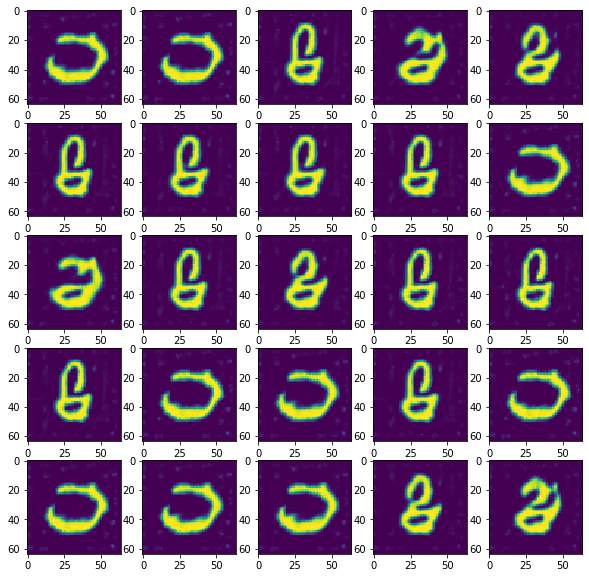

In [0]:
display_images(fake_image_batch)

In [0]:
print(fake_image_batch[0])


NameError: ignored

In [0]:
print(torch.cuda.get_device_name(0))

Tesla T4
